# Continuous ensemble training
Now that the data, the network frameworks and the training loops are set up, we can investigate fruther.

In [43]:
# Reload module in case of changes
importlib.reload(training)

<module 'lib.training' from '/Users/floyd/Documents/Studium/BAE/continuous_training_using_ensemble_networks/notebooks/../lib/training.py'>

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

import sys; sys.path.insert(0, '..')
import importlib

from lib import data, networks, training, utils

## Load preprocessed dataset

In [3]:
# load 10 class data
train_ds_pre, train_ds_post, test_ds, train_generator, test_generator = data.load_data(rotation=25)
dataset_shape = (tf.TensorSpec(shape=(28,28,1), dtype=tf.float64),
                tf.TensorSpec(shape=(10,), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32))

2022-03-22 16:07:06.549869: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Have a look at the normal data

2022-03-22 16:07:06.935317: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


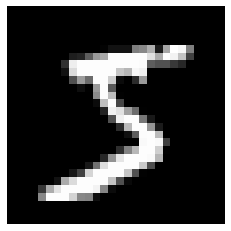

In [4]:
for x, y in train_ds_pre.take(1):
    utils.plot(x)

## Have a look at the generator data

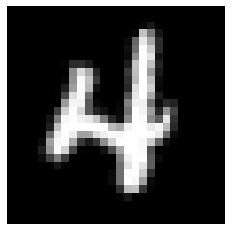

In [5]:
for x, y in test_generator:
    utils.plot(tf.convert_to_tensor(x))
    break

## Initialize the models

In [6]:
num_classes = 10
# Small model
model1 = networks.NN([128, 128], num_classes)
# Broad Model
model2 = networks.NN([512], num_classes)
# Mixed Model
model3 = networks.NN([256, 256], num_classes)
# cnn
model4 = networks.CNN([(32, 3), (64, 5), (128, 7)], num_classes)
# cnn small
model5 = networks.CNN([(16, 3), (32, 3), (64, 5)], num_classes)
# ensemble
ensemble = networks.Ensemble([model1, model2, model3, model4, model5])

## Load the weights from pre-training

In [7]:
model1.load_weights('../models/NN128128')
model2.load_weights('../models/NN512')
model3.load_weights('../models/NN256256')
model4.load_weights('../models/CNN3264128')
model5.load_weights('../models/CNN163264')

## Maybe pre-train more

In [ ]:
training.pretraining(model1, train_ds_pre, test_ds, 10)

In [ ]:
training.pretraining(model2, train_ds_pre, test_ds, 10)

In [ ]:
training.pretraining(model3, train_ds_pre, test_ds, 10)

In [ ]:
training.pretraining(model4, train_ds_pre, test_ds, 5)

In [ ]:
training.pretraining(model5, train_ds_pre, test_ds, 5)

In [45]:
model1.load_weights('../models/NN128128extra')
model2.load_weights('../models/NN512extra')
model3.load_weights('../models/NN256256extra')
model4.load_weights('../models/CNN3264128extra')
model5.load_weights('../models/CNN163264extra')

## Ensemble accuracy on normal test data after pre training

In [34]:
_, acc = training.test_ensemble(ensemble, test_ds, tf.keras.losses.CategoricalCrossentropy())

Testing models in ensemble
Model: __ 0
LOSS 0.36880322932442533 ::: ACC 0.9025909810126582
Model: __ 1
LOSS 0.3066557862713367 ::: ACC 0.9145569620253164
Model: __ 2
LOSS 0.30450712950735154 ::: ACC 0.9108979430379747
Model: __ 3
LOSS 0.1074675908754285 ::: ACC 0.9657832278481012
Model: __ 4
LOSS 0.1239947147337319 ::: ACC 0.9635087025316456
Ensemble:
LOSS nan ::: ACC 0.9072389240506329


## Ensemble accuracy on generator after pre-training

In [46]:
_, acc = training.test_ensemble(ensemble, test_generator, tf.keras.losses.CategoricalCrossentropy())

Testing models in ensemble
Model: __ 0
LOSS 0.6371827441684021 ::: ACC 0.8067193280671933
Model: __ 1
LOSS 0.9187578268524879 ::: ACC 0.7193280671932807
Model: __ 2
LOSS 0.6552799365229068 ::: ACC 0.8018198180181981
Model: __ 3
LOSS 1.2108694402884281 ::: ACC 0.5734426557344265
Model: __ 4
LOSS 0.2878545954804374 ::: ACC 0.911008899110089
Ensemble:
LOSS nan ::: ACC 0.7395260473952605


## Run Post-training dataset through ensemble

In [10]:
utils.run_data(ensemble, generator=train_generator, datapoints=10000)

In [ ]:
tf.data.experimental.save(ensemble.continuous_training_data, '../datasets/ensemble_extra_contrain_ro30_50000', compression='GZIP')
#ensemble.set_continuous_training_data(tf.data.experimental.load('../datasets/ensemble_contrain_ro20', compression='GZIP'))
#ensemble.set_continuous_training_data(tf.data.experimental.load('../datasets/ensemble_extra_contrain_ro30', compression='GZIP', element_spec=dataset_shape))

## Check how much data we gathered to train on

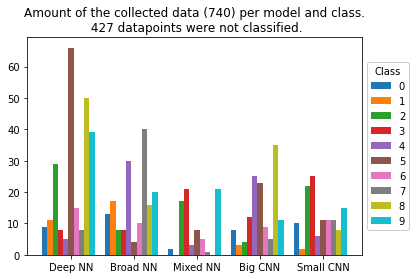

In [42]:
utils.plot_collected_data(ensemble)

## Cycle through data and train on the collected datapoints

In [ ]:
training.cycle(ensemble,
               train_generator,
               test_generator,
               epochs=2,
               batch_size=1,
               cycles=3,
               data_per_cycle=1000,
               name="Run01")

## Training individual networks on the collected data

In [21]:
training.continuous_training(ensemble, generator, epochs=10)

Model: ___ 0
Epoch: _ 0
LOSS 0.7223452279471221 ::: ACC 0.7757224277572243
Epoch: _ 1
LOSS 0.7315480729675654 ::: ACC 0.773922607739226
Epoch: _ 2
LOSS 0.7426768117166632 ::: ACC 0.7683231676832317
Epoch: _ 3
LOSS 0.7422166025732039 ::: ACC 0.7729227077292271
Epoch: _ 4
LOSS 0.7362695033930681 ::: ACC 0.7735226477352265
Epoch: _ 5
LOSS 0.7185815512599849 ::: ACC 0.7743225677432257
Epoch: _ 6
LOSS 0.7415247742518181 ::: ACC 0.7696230376962304
Epoch: _ 7
LOSS 0.7228660416765048 ::: ACC 0.77002299770023
Epoch: _ 8
LOSS 0.7291483263104354 ::: ACC 0.777022297770223
Epoch: _ 9
LOSS 0.7288720483704768 ::: ACC 0.772022797720228
Model: ___ 1
Epoch: _ 0
LOSS 0.778051452945954 ::: ACC 0.7701229877012299
Epoch: _ 1
LOSS 0.7675268259254394 ::: ACC 0.7709229077092291
Epoch: _ 2
LOSS 0.7660594572916282 ::: ACC 0.7732226777322267
Epoch: _ 3
LOSS 0.795807834399112 ::: ACC 0.7648235176482352
Epoch: _ 4
LOSS 0.7652463035084038 ::: ACC 0.7727227277272273
Epoch: _ 5
LOSS 0.763471393025117 ::: ACC 0.7700229

## Test ensemble accuracy after continuous training

In [ ]:
_, acc = training.test(ensemble, generator, tf.keras.losses.CategoricalCrossentropy())
acc

## Get new data to train on

In [18]:
utils.run_data(ensemble, generator=generator, datapoints=10000)

## Have a look at it

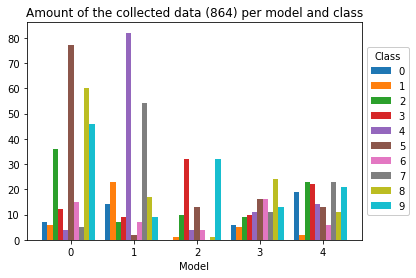

In [20]:
utils.plot_collected_data(ensemble)

In [19]:
print(len(ensemble.continuous_training_data), len(ensemble.missed_data))

864 541


## Train some more

In [21]:
training.continuous_training(ensemble, generator, epochs=2)

Model: ___ 0
Epoch: _ 0
LOSS 0.7460490852017386 ::: ACC 0.7716228377162284
Epoch: _ 1
LOSS 0.7392996562110873 ::: ACC 0.7725227477252274
Model: ___ 1
Epoch: _ 0
LOSS 0.7934451586806117 ::: ACC 0.7659234076592341
Epoch: _ 1
LOSS 0.7806305042278281 ::: ACC 0.7662233776622338
Model: ___ 2
Epoch: _ 0
LOSS 0.6804282106688107 ::: ACC 0.7889211078892111
Epoch: _ 1
LOSS 0.6744933953043726 ::: ACC 0.7941205879412059
Model: ___ 3
Epoch: _ 0
LOSS 0.3419744286580274 ::: ACC 0.896010398960104
Epoch: _ 1
LOSS 0.3493182487267136 ::: ACC 0.8954104589541045
Model: ___ 4
Epoch: _ 0
LOSS 0.37836802872159775 ::: ACC 0.8796120387961204
Epoch: _ 1
LOSS 0.37474113243389506 ::: ACC 0.8838116188381162


## Test ensemble again